In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
path = "./Data/"

c:\Users\asus\anaconda3\envs\pt-gpu\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def read(pathname):
    df = pd.read_csv(pathname, header=[0], index_col = [0])
    return df

In [3]:
X_train_sc_df = read(path+"Processed/X_train_sc.csv")
X_train_mmx_df = read(path+"Processed/X_train_mmx.csv")
X_test_sc_df = read(path+"Processed/X_test_sc.csv")
X_test_mmx_df = read(path+"Processed/X_test_mmx.csv")
Y_train_df = read(path+"Processed/Y_train.csv")
Y_test_df = read(path+"Processed/Y_test.csv")

In [4]:
X_train_sc = X_train_sc_df.values
X_train_mmx = X_train_mmx_df.values
X_test_sc = X_test_sc_df.values
X_test_mmx = X_test_mmx_df.values
Y_train = Y_train_df.values
Y_test = Y_test_df.values

# Ridge Regression

## SC

In [72]:
# Define the pipeline
pipeline = Pipeline([
    ('ridge', Ridge())
])

# Define the hyperparameters to tune with grid search
parameters = {
    'ridge__alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 10],
    'ridge__fit_intercept': [True, False],
    'ridge__solver': ["auto", "svd", "lsqr", "saga"]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5)

grid_search.fit(X_train_sc, Y_train)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Hyperparameters:  {'ridge__alpha': 1, 'ridge__fit_intercept': True, 'ridge__solver': 'svd'}
Best Score:  0.7140289806597171


In [73]:
# Extract the top 5 results from cv_results_
results_df = pd.DataFrame(grid_search.cv_results_)
top_5_results = results_df.nlargest(5, 'mean_test_score')

# Print the top 5 results
print(top_5_results[['params', 'mean_test_score', 'std_test_score']])

                                               params  mean_test_score  \
33  {'ridge__alpha': 1, 'ridge__fit_intercept': Tr...         0.714029   
32  {'ridge__alpha': 1, 'ridge__fit_intercept': Tr...         0.714029   
35  {'ridge__alpha': 1, 'ridge__fit_intercept': Tr...         0.714028   
30  {'ridge__alpha': 0.5, 'ridge__fit_intercept': ...         0.714013   
31  {'ridge__alpha': 0.5, 'ridge__fit_intercept': ...         0.714010   

    std_test_score  
33        0.018586  
32        0.018586  
35        0.018585  
30        0.018746  
31        0.018752  


In [74]:
y_pred = grid_search.best_estimator_.predict(X_train_sc)

mse = mean_squared_error(Y_train, y_pred)
print("Mean squared error:", mse)

r2 = r2_score(Y_train, y_pred)
print("R-squared score:", r2)

Mean squared error: 47775.56270594479
R-squared score: 0.7210425108635984


In [75]:
y_pred = grid_search.best_estimator_.predict(X_test_sc)

mse = mean_squared_error(Y_test, y_pred)
print("Mean squared error:", mse)

r2 = r2_score(Y_test, y_pred)
print("R-squared score:", r2)

Mean squared error: 48002.946467626025
R-squared score: 0.721231310067469


In [77]:
ridge_reg = Ridge(alpha=1, fit_intercept = True, solver = "svd")
ridge_reg.fit(X_train_sc_df, Y_train_df)
print("Coefficients:", ridge_reg.coef_)

Coefficients: [[  46.7604659    -7.61133906  157.20536499  -88.78607212  383.93255209
  -320.27856628 -144.15619558  500.08348991 -273.30248126  219.23038722
   114.3387049   -99.64373154   -6.60675488  -58.13157607  211.39537953
   155.25672302 -137.85669128 -215.92588623  373.28035    -329.77390808
  -210.40079839   48.83533183  -10.8497483   186.63205864 -296.598934
  -197.02812496  307.87687392 -461.42483133  -25.80442755  179.35238496
   135.68065231  -63.62234195  -88.30467081   28.6246456    85.59213017]]


In [112]:
alphas = [0.001, 0.01, 0.1, 0.5, 1, 2, 10]

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=True, solver = 'svd')
    ridge.fit(X_train_sc, Y_train)
    coefs.append(ridge.coef_.ravel())
    
coefs = np.array(coefs)

Text(0.5, 1.0, 'L2 Norm')

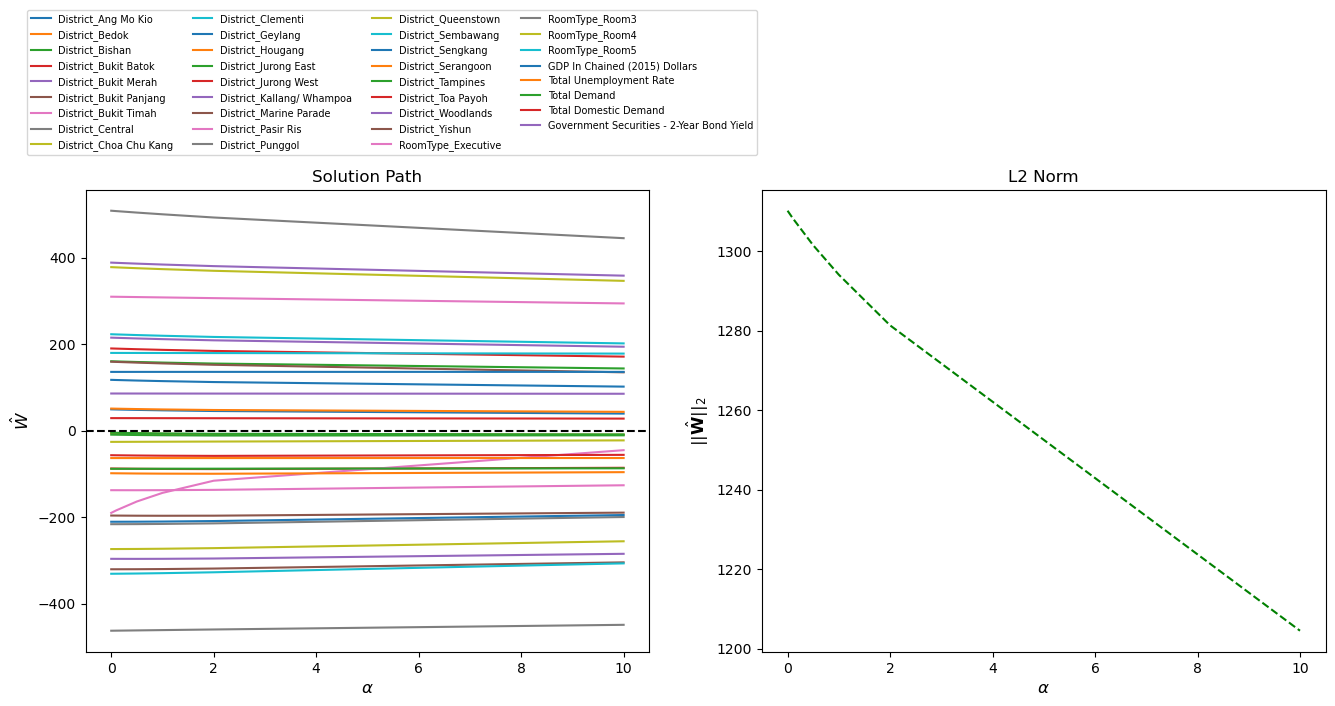

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

labels = X_train_sc_df.columns.values
for i in range(coefs.shape[1]):
    label=labels[i]
    ax1.plot(alphas, coefs[:,i],label=labels[i])

ax1.axhline(y=0,xmin=0,xmax=10,color='black',linestyle='--')
ax1.set_xlabel(r'$\alpha$',fontsize=12)
ax1.set_ylabel(r'$\hat{W}$',fontsize=12)
ax1.set_title('Solution Path',fontsize=12)
ax1.axis('tight')
ax1.legend(bbox_to_anchor=(1.2, 1.4), ncol = 4, fontsize = 7)

l2norm = np.linalg.norm(coefs, ord=2, axis=1)

ax2.plot(alphas,l2norm,'--g')
ax2.set_xlabel(r'$\alpha$',fontsize=12)
ax2.set_ylabel(r'$||\hat{\mathbf{W}}||_2$',fontsize=12)
ax2.set_title('L2 Norm',fontsize=12)

## MMX

In [143]:
# Define the pipeline
pipeline = Pipeline([
    ('ridge', Ridge())
])

# Define the hyperparameters to tune with grid search
parameters = {
    'ridge__alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 10],
    'ridge__fit_intercept': [True, False],
    'ridge__solver': ["auto", "svd", "lsqr", "saga"]
}

grid_search = GridSearchCV(pipeline, parameters, cv=5)

grid_search.fit(X_train_mmx, Y_train)

# Print the best hyperparameters and the corresponding score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)


Best Hyperparameters:  {'ridge__alpha': 1, 'ridge__fit_intercept': True, 'ridge__solver': 'svd'}
Best Score:  0.71402321039458


In [144]:
# Extract the top 5 results from cv_results_
results_df = pd.DataFrame(grid_search.cv_results_)
top_5_results = results_df.nlargest(5, 'mean_test_score')

# Print the top 5 results
print(top_5_results[['params', 'mean_test_score', 'std_test_score']])

                                               params  mean_test_score  \
33  {'ridge__alpha': 1, 'ridge__fit_intercept': Tr...         0.714023   
32  {'ridge__alpha': 1, 'ridge__fit_intercept': Tr...         0.714023   
35  {'ridge__alpha': 1, 'ridge__fit_intercept': Tr...         0.714022   
34  {'ridge__alpha': 1, 'ridge__fit_intercept': Tr...         0.714019   
26  {'ridge__alpha': 0.5, 'ridge__fit_intercept': ...         0.714011   

    std_test_score  
33        0.018466  
32        0.018466  
35        0.018465  
34        0.018478  
26        0.018630  


In [146]:
y_pred = grid_search.best_estimator_.predict(X_train_mmx)

mse = mean_squared_error(Y_train, y_pred)
print("Mean squared error:", mse)

r2 = r2_score(Y_train, y_pred)
print("R-squared score:", r2)

Mean squared error: 47778.114624180744
R-squared score: 0.7210276104278261


In [147]:
y_pred = grid_search.best_estimator_.predict(X_test_mmx)

mse = mean_squared_error(Y_test, y_pred)
print("Mean squared error:", mse)

r2 = r2_score(Y_test, y_pred)
print("R-squared score:", r2)

Mean squared error: 48015.252013243844
R-squared score: 0.7211598477701889


# XGBoost

## SC

In [5]:
steps = [
    ('xgb', xgb.XGBRegressor())
]

parameters = {
    'xgb__learning_rate': [0.1, 0.2, 0.3, 0.5],
    'xgb__max_depth': [2, 3, 5, 7],
    'xgb__n_estimators': [50, 100, 200, 300],
    
}

# Create the pipeline
pipeline = Pipeline(steps)

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_sc, Y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best Score: ", -grid_search.best_score_)


Best hyperparameters: {'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}
Best Score:  6531.481250564789


In [6]:
# Extract the top 5 results from cv_results_
results_df = pd.DataFrame(grid_search.cv_results_)
top_5_results = results_df.nlargest(5, 'mean_test_score')

# Print the top 5 results
print(top_5_results[['params', 'mean_test_score', 'std_test_score']])

                                               params  mean_test_score  \
38  {'xgb__learning_rate': 0.3, 'xgb__max_depth': ...     -6531.481251   
51  {'xgb__learning_rate': 0.5, 'xgb__max_depth': ...     -6741.368938   
39  {'xgb__learning_rate': 0.3, 'xgb__max_depth': ...     -6758.088157   
23  {'xgb__learning_rate': 0.2, 'xgb__max_depth': ...     -7009.527032   
54  {'xgb__learning_rate': 0.5, 'xgb__max_depth': ...     -7094.688904   

    std_test_score  
38     2979.370905  
51     2677.592849  
39     2872.612969  
23     2680.175931  
54     2661.992340  


In [7]:
y_pred = grid_search.best_estimator_.predict(X_train_sc)

mse = mean_squared_error(Y_train, y_pred)
print("Mean squared error:", mse)

r2 = r2_score(Y_train, y_pred)
print("R-squared score:", r2)

Mean squared error: 3486.5386509331042
R-squared score: 0.9796423942962729


In [8]:
y_pred = grid_search.best_estimator_.predict(X_test_sc)

mse = mean_squared_error(Y_test, y_pred)
print("Mean squared error:", mse)

r2 = r2_score(Y_test, y_pred)
print("R-squared score:", r2)

Mean squared error: 5145.553323458116
R-squared score: 0.9701181018143168


In [9]:
xgb_model = xgb.XGBRegressor(learning_rate = 0.3, max_depth = 3, n_estimators = 200)
xgb_model.fit(X_train_sc_df, Y_train)

c:\Users\asus\anaconda3\envs\pt-gpu\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

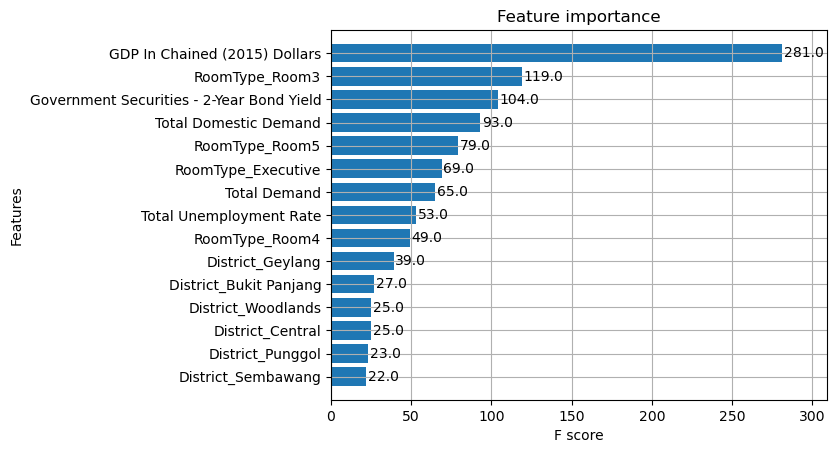

In [10]:
plot_importance(xgb_model, height=0.8, max_num_features=15)

c:\Users\asus\anaconda3\envs\pt-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


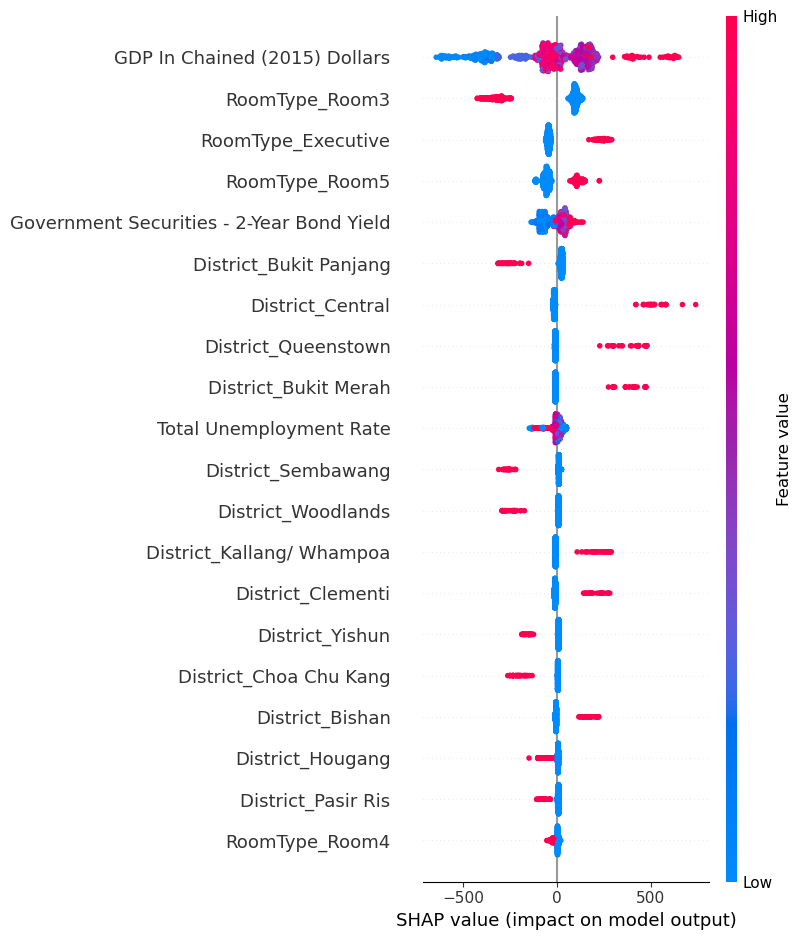

In [11]:
import shap
explainer = shap.Explainer(xgb_model, X_train_sc_df)
shap_values = explainer(X_test_sc_df)
shap.summary_plot(shap_values, X_test_sc_df)

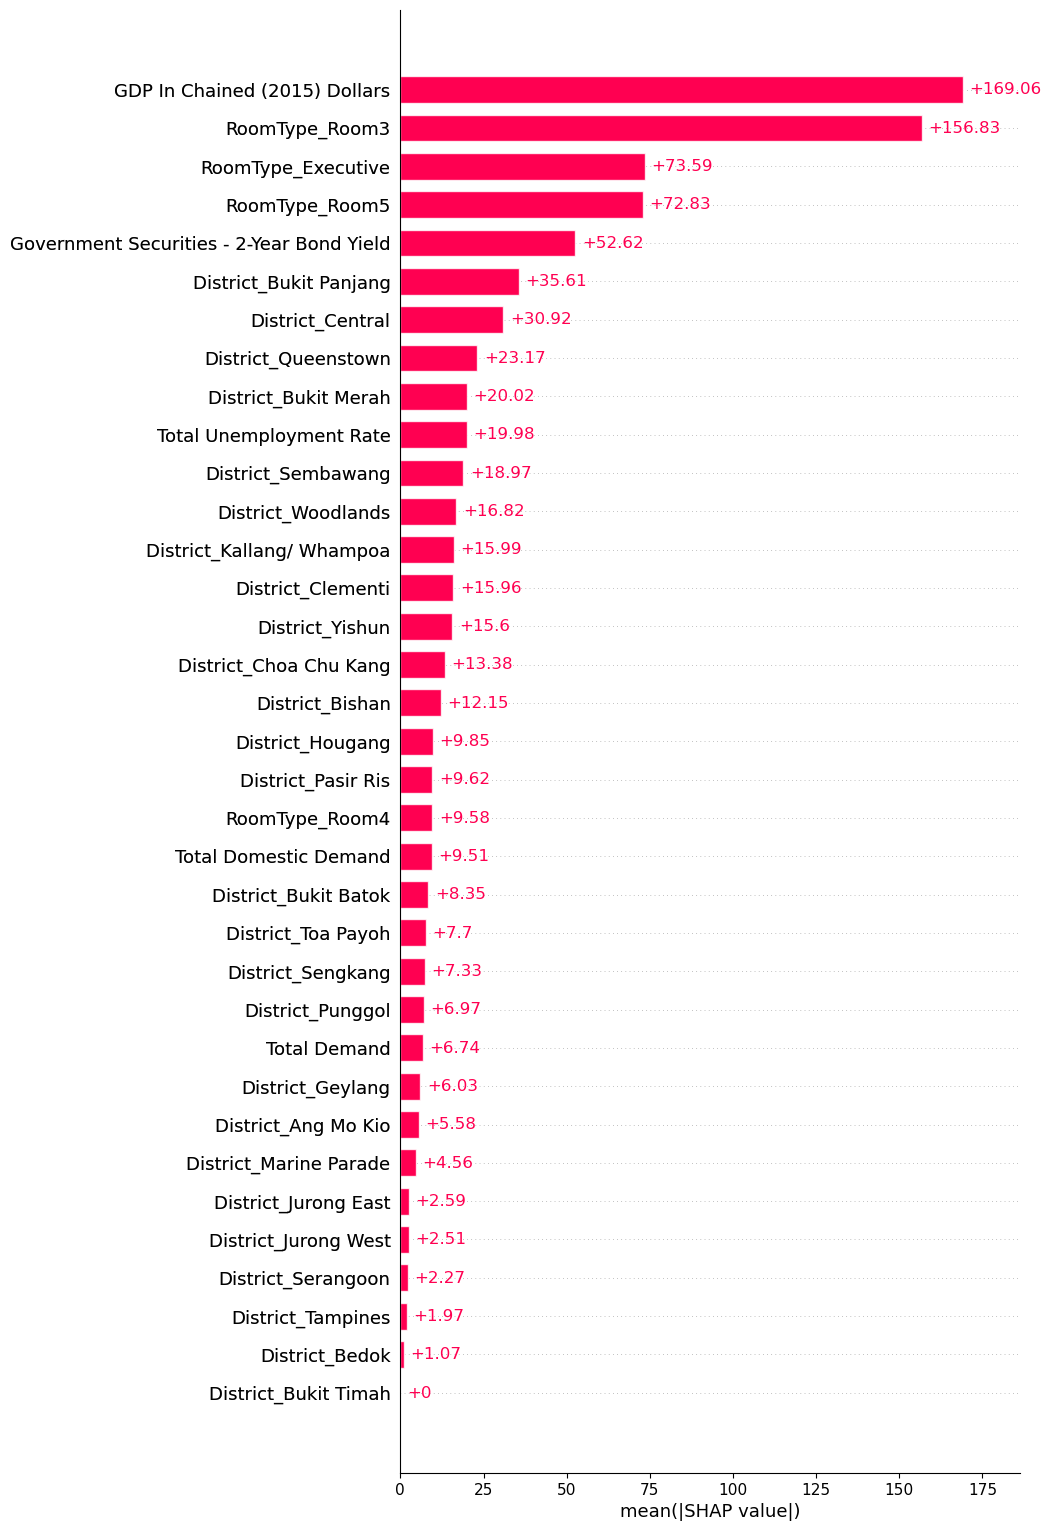

In [12]:
shap.plots.bar(shap_values, max_display=None)

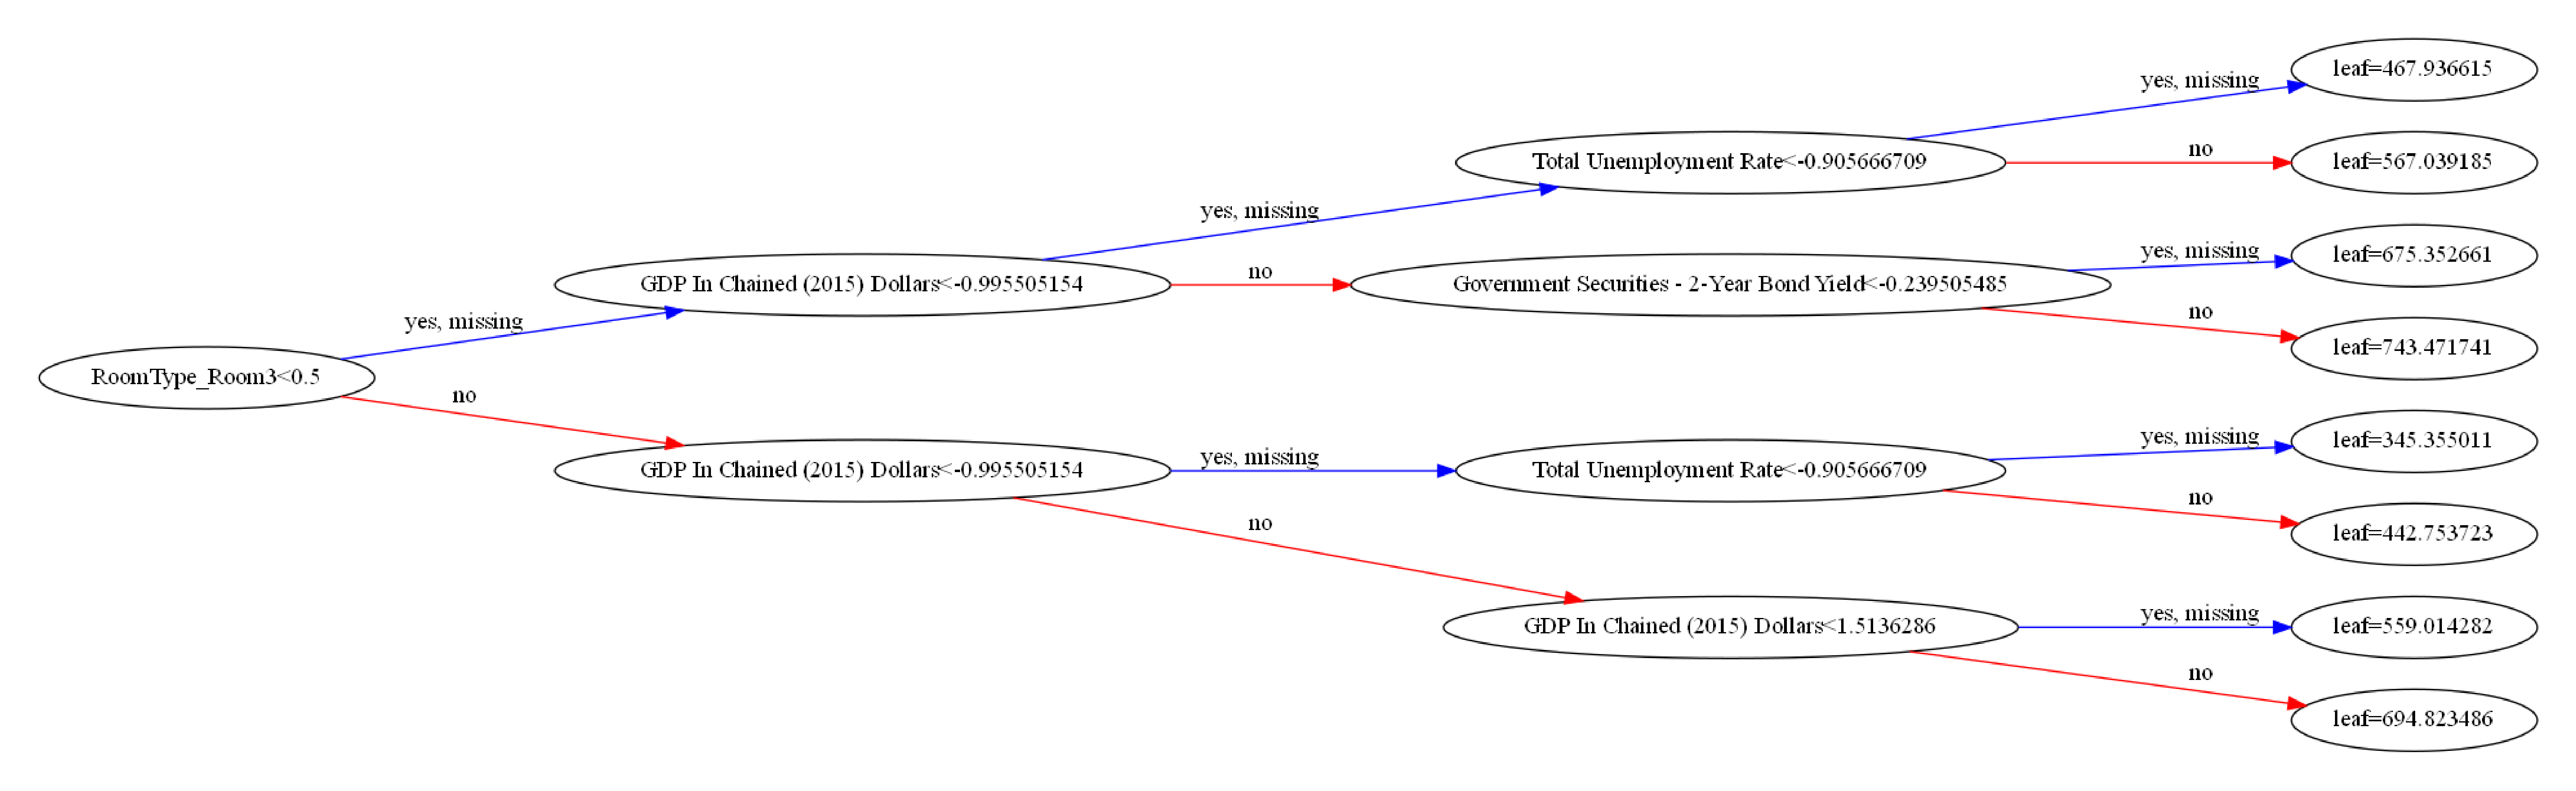

In [13]:
feature_names = X_train_sc_df.columns
fig, ax = plt.subplots(figsize=(10, 10), dpi = 800)
xgb.plot_tree(xgb_model, num_trees=0, rankdir='LR', ax = ax)
plt.show()

In [14]:
X_predict_df = read(path+"Geo/X_predict.csv")

In [15]:
y_pred = grid_search.best_estimator_.predict(X_predict_df)

In [16]:
y_pred = pd.DataFrame(y_pred)

In [17]:
y_pred.to_csv(path +"Geo\Geodata.csv")

In [18]:
Geodata = pd.read_csv(path +"Geo\Geodata.csv", header=[0])

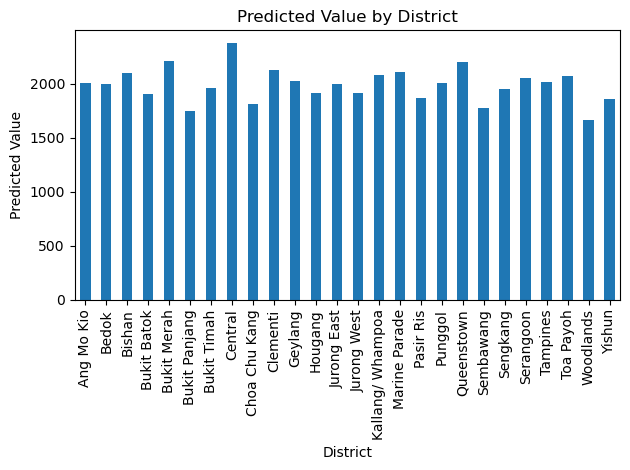

In [21]:
Geodata.plot(kind='bar', x='Position', y='Predicted Value', legend=None)
plt.title('Predicted Value by District')
plt.xlabel('District')
plt.ylabel('Predicted Value')
plt.tight_layout()
plt.show()

## MMX

In [215]:
steps = [
    ('xgb', xgb.XGBRegressor())
]

parameters = {
    'xgb__learning_rate': [0.1, 0.2, 0.3, 0.5],
    'xgb__max_depth': [2, 3, 5, 7],
    'xgb__n_estimators': [50, 100, 200, 300],
    
}

# Create the pipeline
pipeline = Pipeline(steps)

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_mmx, Y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
print("Best Score: ", -grid_search.best_score_)


Best hyperparameters: {'xgb__learning_rate': 0.3, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}
Best Score:  6532.65692562565


In [219]:
y_pred = grid_search.best_estimator_.predict(X_train_mmx)

mse = mean_squared_error(Y_train, y_pred)
print("Mean squared error:", mse)

r2 = r2_score(Y_train, y_pred)
print("R-squared score:", r2)

Mean squared error: 3486.5386509331042
R-squared score: 0.9796423942962729


In [220]:
y_pred = grid_search.best_estimator_.predict(X_test_mmx)

mse = mean_squared_error(Y_test, y_pred)
print("Mean squared error:", mse)

r2 = r2_score(Y_test, y_pred)
print("R-squared score:", r2)

Mean squared error: 5143.327603680008
R-squared score: 0.970131027291446


# Random Forest

## SC

In [233]:
pipe_rf = Pipeline([('rf', RandomForestRegressor())])

# Define the hyperparameters grid for Random Forest Regressor
param_grid_rf = {
    'rf__max_features': [None, "sqrt", 0.9],
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [5, 10, 15]
}

# Define Grid Search cross-validation
grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5)

# Fit Grid Search cross-validation to the train dataset
grid_search_rf.fit(X_train_sc, Y_train.ravel())

# Print the best parameters and score
print("Best parameters: ", grid_search_rf.best_params_)
print("Best score: ", grid_search_rf.best_score_)

Best parameters:  {'rf__max_depth': 15, 'rf__max_features': None, 'rf__n_estimators': 150}
Best score:  0.9014233926183743


In [234]:
y_pred = grid_search_rf.best_estimator_.predict(X_train_sc)

mse = mean_squared_error(Y_train, y_pred)
print("Mean squared error:", mse)

r2 = r2_score(Y_train, y_pred)
print("R-squared score:", r2)

Mean squared error: 8157.337569171761
R-squared score: 0.952369992576748


In [235]:
y_pred = grid_search_rf.best_estimator_.predict(X_test_sc)

mse = mean_squared_error(Y_test, y_pred)
print("Mean squared error:", mse)

r2 = r2_score(Y_test, y_pred)
print("R-squared score:", r2)

Mean squared error: 15107.439723573423
R-squared score: 0.9122661942675636


In [229]:
rf = RandomForestRegressor(max_depth = 15, max_features = None, n_estimators = 100)
rf_reg = rf.fit(X_train_sc, Y_train.ravel())

Feature ranking:
1. feature 30 (0.325388)
2. feature 27 (0.272854)
3. feature 34 (0.078613)
4. feature 4 (0.043108)
5. feature 18 (0.039608)
6. feature 28 (0.036644)
7. feature 7 (0.031942)
8. feature 31 (0.023751)
9. feature 5 (0.018759)
10. feature 24 (0.016826)
11. feature 9 (0.012449)
12. feature 14 (0.012306)
13. feature 19 (0.011052)
14. feature 33 (0.009173)
15. feature 23 (0.008416)
16. feature 32 (0.007766)
17. feature 8 (0.007286)
18. feature 2 (0.006782)
19. feature 17 (0.005272)
20. feature 29 (0.004854)
21. feature 10 (0.004671)
22. feature 25 (0.004266)
23. feature 20 (0.003487)
24. feature 26 (0.003271)
25. feature 15 (0.002372)
26. feature 21 (0.001617)
27. feature 11 (0.001540)
28. feature 13 (0.001353)
29. feature 3 (0.001351)
30. feature 12 (0.000850)
31. feature 22 (0.000731)
32. feature 0 (0.000675)
33. feature 1 (0.000492)
34. feature 16 (0.000457)
35. feature 6 (0.000016)


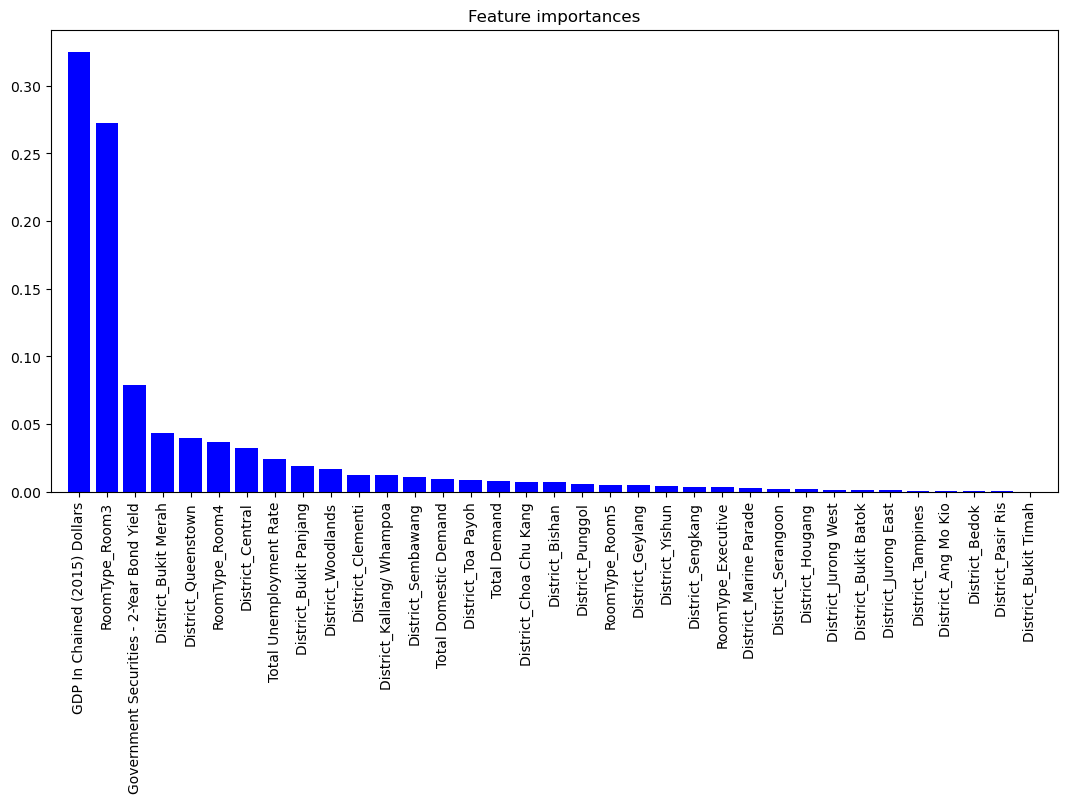

In [244]:
# Get the feature importances
importances = rf_reg.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_sc_df.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Get the column names
column_names = X_train_sc_df.columns
# Plot the feature importances
fig = plt.figure(figsize=(13, 6))
plt.title("Feature importances")
plt.bar(range(X_train_sc_df.shape[1]), importances[indices], color="b", align="center")
plt.xticks(range(X_train_sc_df.shape[1]), column_names[indices], rotation=90)
plt.xlim([-1, X_train_sc_df.shape[1]])
plt.show()

## MMX

In [223]:
pipe_rf = Pipeline([('rf', RandomForestRegressor())])

# Define the hyperparameters grid for Random Forest Regressor
param_grid_rf = {
    'rf__max_features': [None, "sqrt", 0.2],
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [5, 10, 15]
}

# Define Grid Search cross-validation
grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5)

# Fit Grid Search cross-validation to the train dataset
grid_search_rf.fit(X_train_mmx, Y_train.ravel())

# Print the best parameters and score
print("Best parameters: ", grid_search_rf.best_params_)
print("Best score: ", grid_search_rf.best_score_)

Best parameters:  {'rf__max_depth': 15, 'rf__max_features': None, 'rf__n_estimators': 150}
Best score:  0.9013757264727568


In [224]:
y_pred = grid_search_rf.best_estimator_.predict(X_train_mmx)

mse = mean_squared_error(Y_train, y_pred)
print("Mean squared error:", mse)

r2 = r2_score(Y_train, y_pred)
print("R-squared score:", r2)

Mean squared error: 8359.920032624583
R-squared score: 0.9511871306250073


In [225]:
y_pred = grid_search_rf.best_estimator_.predict(X_test_mmx)

mse = mean_squared_error(Y_test, y_pred)
print("Mean squared error:", mse)

r2 = r2_score(Y_test, y_pred)
print("R-squared score:", r2)

Mean squared error: 15166.898457935662
R-squared score: 0.9119208980992465


# LSTM

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Y_train_sc_df = pd.DataFrame(scaler.fit_transform(Y_train_df), columns = ["Rental Price"])
Y_test_sc_df = pd.DataFrame(scaler.transform(Y_test_df), columns = ["Rental Price"])

In [19]:
Train_sc = pd.merge(Y_train_sc_df, X_train_sc_df, on=Y_train_df.index, how = "left")
Train_sc = Train_sc.drop("key_0", axis = 1)
Test_sc = pd.merge(Y_test_sc_df, X_test_sc_df, on=Y_test_df.index, how = "left")
Test_sc = Test_sc.drop("key_0", axis = 1)

## SC

In [16]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [20]:
train_size = int(len(X_train_sc_df) * 0.8)

# Create sequences for the LSTM model
SEQ_LEN = 10
def create_sequences(data):
    X = []
    y = []
    for i in range(SEQ_LEN, len(data)):
        X.append(data[i-SEQ_LEN:i, :])
        y.append(data[i, 0])
    X = np.array(X)
    y = np.array(y)
    return X, y
X_train, y_train = create_sequences(Train_sc.values)
X_test, y_test = create_sequences(Test_sc.values)
# Convert the data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [22]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).cuda()
        c0 = torch.zeros(1, x.size(0), self.hidden_size).cuda()
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
# Instantiate the LSTM model
INPUT_SIZE = X_train.shape[2]
HIDDEN_SIZE = 64
OUTPUT_SIZE = 1
model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

In [23]:
# Move the model and data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [24]:
# Train the LSTM model
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss = 0.0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(X_batch.to(device))
        loss = criterion(outputs.squeeze(), y_batch.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            outputs = model(X_batch.to(device))
        loss = criterion(outputs.squeeze(), y_batch.to(device))
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

Epoch 1/10, Train Loss: 1.000800, Test Loss: 0.063427
Epoch 2/10, Train Loss: 0.997162, Test Loss: 0.063171
Epoch 3/10, Train Loss: 0.994890, Test Loss: 0.063421
Epoch 4/10, Train Loss: 0.992172, Test Loss: 0.064723
Epoch 5/10, Train Loss: 0.992365, Test Loss: 0.063869
Epoch 6/10, Train Loss: 0.987540, Test Loss: 0.063655
Epoch 7/10, Train Loss: 0.976797, Test Loss: 0.062834
Epoch 8/10, Train Loss: 0.972328, Test Loss: 0.062071
Epoch 9/10, Train Loss: 0.961080, Test Loss: 0.065195
Epoch 10/10, Train Loss: 0.952711, Test Loss: 0.062610


In [25]:
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        output = model(X_batch)
        y_pred.append(output.squeeze().detach().cpu().numpy())
        y_true.append(y_batch.squeeze().detach().cpu().numpy())

# concatenate the predicted and true values from each batch
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)


In [26]:
# inverse transform the scaled values
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

# calculate the metrics
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# print the results
print("Test MSE: ", mse)
print("Test R-squared: ", r2)

Test MSE:  174378.89
Test R-squared:  -0.0122645806390409
